In [4]:
import pandas as pd, os
mosaic = "/home/alice/work/mosaic/outputs/ppl_mosaic"
mteb = "/home/alice/work/mosaic/outputs/ppl_sib"

data = []

language_mapping = {
    "mimic": "english",
    "padchest": "spanish",
    "padchest_EN": "english",
    "casia": "french",
    "danskcxr": "danish"
}

for file in os.listdir(mosaic):
    df = pd.read_csv(os.path.join(mosaic, file), index_col=0)
    df['model'] = file.replace(".csv", "")
    df['source'] = 'mosaic'
    df["dataset"] = df.index
    df["language"] = df["dataset"].map(language_mapping)
    df = df.reset_index(drop=True)
    data.append(df)

for file in os.listdir(mteb):
    df = pd.read_csv(os.path.join(mteb, file), index_col=0)
    df['model'] = file.replace(".csv", "")
    df['source'] = 'mteb'
    df["language"] = df.index
    df = df.reset_index(drop=True)
    data.append(df)

data = pd.concat(data)
data.head(5)

,ppl,model,source,dataset,language
0,13.343459,MMed-Llama-3-8B,mosaic,mimic,english
1,18.318798,MMed-Llama-3-8B,mosaic,padchest,spanish
2,34.548523,MMed-Llama-3-8B,mosaic,padchest_EN,english
3,6.782864,MMed-Llama-3-8B,mosaic,casia,french
4,41.261658,MMed-Llama-3-8B,mosaic,danskcxr,danish


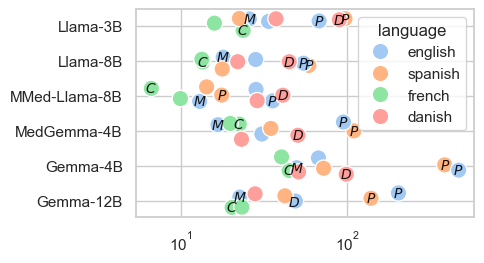

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set(style="whitegrid")
df = data.copy()

def extract_initial(row):
    dataset_mapping = {
        "mimic": "$M$",
        "padchest": "$P$",
        "padchest_EN": "$P$",
        "casia": "$C$",
        "danskcxr": "$D$",
        None: ""
    }
    return dataset_mapping.get(row, "")

def model_mapping(model_name):
    mapping = {
        "Llama-3.2-3B-Instruct": "Llama-3B",
        "Llama-3.1-8B-Instruct": "Llama-8B",
        "MMed-Llama-3-8B": "MMed-Llama-8B",
        "gemma-3-4b-it": "Gemma-4B",
        "medgemma-4b-it": "MedGemma-4B",
        "gemma-3-12b-it": "Gemma-12B"
    }
    return mapping.get(model_name, model_name)

def model_order(model_name):
    order = {
        "Llama-3B": 1,
        "Llama-8B": 2,
        "MMed-Llama-8B": 3,
        "MedGemma-4B": 4,
        "Gemma-4B": 5,
        "Gemma-12B": 6
    }
    return order.get(model_name, 99)

df['dataset_initial'] = df['dataset'].apply(extract_initial)
df['model'] = df['model'].apply(model_mapping)
df['model_order'] = df['model'].apply(model_order)
df = df.sort_values(by=['model_order', 'model'])
df['model'] = pd.Categorical(df['model'], categories=df['model'].unique(), ordered=True)

# --- Horizontal jitter (bigger factor) ---
df['ppl_jitter'] = df['ppl'] * (1 + np.random.uniform(-0.05, 0.05, len(df)))

# --- Vertical jitter ---
model_positions = {model: i for i, model in enumerate(df['model'].cat.categories)}
df['model_pos'] = df['model'].map(model_positions).astype(float)   # ensure numeric
df['model_pos_jitter'] = df['model_pos'] + np.random.uniform(-0.25, 0.25, len(df))

plt.figure(figsize=(5,2.8))

model_order_dict = {
    "Llama-3B": 1,
    "Llama-8B": 2,
    "MMed-Llama-8B": 3,
    "MedGemma-4B": 4,
    "Gemma-4B": 5,
    "Gemma-12B": 6
}

# --- Model order ---
ordered_models = [m for m, _ in sorted(model_order_dict.items(), key=lambda x: x[1]) if m in df['model'].unique()]
df['model'] = pd.Categorical(df['model'], categories=ordered_models, ordered=True)

# --- Vertical positions for plotting ---
# Reverse order so top = highest order
model_positions = {model: len(ordered_models) - 1 - i for i, model in enumerate(ordered_models)}
df['model_pos'] = df['model'].map(model_positions).astype(float)
df['model_pos_jitter'] = df['model_pos'] + np.random.uniform(-0.25, 0.25, len(df))

# --- Plot ---
ax = sns.scatterplot(
    data=df,
    x='ppl_jitter',
    y='model_pos_jitter',
    hue='language',
    palette='pastel',
    s=140,
    edgecolor='white'
)

# Restore y-axis labels in correct order
ax.set_yticks(list(model_positions.values()))
ax.set_yticklabels(list(model_positions.keys()))


# Add text at jittered positions too
for i, row in df.iterrows():
    ax.text(
        row['ppl_jitter'],
        row['model_pos_jitter'],
        row['dataset_initial'],
        color='black',
        ha='center',
        va='center',
        fontsize=10,
        fontweight='bold',
        alpha=0.9   
    )

# Set y-axis ticks back to model names
ax.set_yticks(list(model_positions.values()))
ax.set_yticklabels(list(model_positions.keys()))

plt.xlabel("")
plt.ylabel("")
plt.xscale('log')
plt.tight_layout()

plt.savefig("/home/alice/work/mosaic/outputs/ppl_plots/perplexity_scatter.pdf")
plt.show()


In [6]:
debug_mosaic = "/home/alice/work/mosaic/outputs/ppl_debug/ppl_mosaic"
debug_sib = "/home/alice/work/mosaic/outputs/ppl_debug/ppl_sib"

data = []

for file in os.listdir(debug_mosaic):
    df = pd.read_csv(os.path.join(debug_mosaic, file), index_col=0)
    df["model"] = file.replace(".csv", "")
    data.append(df)

for file in os.listdir(debug_sib):
    try: df = pd.read_csv(os.path.join(debug_sib, file), index_col=0)
    except: continue
    df["model"] = file.replace(".csv", "")
    data.append(df)

data = pd.concat(data)

def model_mapping(model_name):
    mapping = {
        "Llama-3.2-3B-Instruct": "Llama-3B",
        "Llama-3.1-8B-Instruct": "Llama-8B",
        "MMed-Llama-3-8B": "MMed-Llama-8B",
        "gemma-3-4b-it": "Gemma-4B",
        "medgemma-4b-it": "MedGemma-4B",
        "gemma-3-12b-it": "Gemma-12B"
    }
    return mapping.get(model_name, model_name)

data['model'] = data['model'].apply(model_mapping)

data

,len_input_ids,ppl,language,model
0,185,11.159510,mimic,MMed-Llama-8B
1,233,8.183950,mimic,MMed-Llama-8B
2,163,19.735453,mimic,MMed-Llama-8B
3,210,14.200131,mimic,MMed-Llama-8B
4,141,16.862476,mimic,MMed-Llama-8B
...,...,...,...,...
3591,25,33.774765,danish,Gemma-12B
3592,44,15.540573,danish,Gemma-12B
3593,17,32.521244,danish,Gemma-12B
3594,37,33.706409,danish,Gemma-12B


In [7]:
data.groupby('language')["ppl"].mean()

language
casia            23.827583
danish           52.619282
danskcxr        150.488922
english          61.886366
french           27.642777
mimic            27.056744
padchest       8909.935133
padchest_EN    5091.291275
spanish          53.329213
Name: ppl, dtype: float64

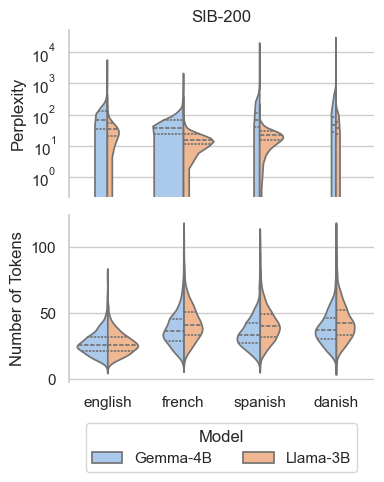

In [8]:
sns_data = data.copy()

sns.set(style="whitegrid")
# Filter to the models you want
show_models = ["Llama-3B", "Gemma-4B"] 
show_languages = ["danish", "english", "spanish", "french"]
sns_data = sns_data[sns_data['model'].isin(show_models)]
sns_data = sns_data[sns_data['language'].isin(show_languages)]

# Create stacked violin plots
fig, axes = plt.subplots(2, 1, figsize=(4, 5), sharex=True)

# Top plot: ppl
sns.violinplot(data=sns_data, x="language", y="ppl", hue="model", split=True, inner="quart", ax=axes[0], palette="pastel")
axes[0].set_title("SIB-200")
axes[0].set_ylabel("Perplexity")
axes[0].get_legend().remove() # turn off legend
axes[0].set_yscale('log')

# Bottom plot: len
sns.violinplot(data=sns_data, x="language", y="len_input_ids", hue="model", split=True, inner="quart", ax=axes[1], palette="pastel")
axes[1].set_title("")
axes[1].set_ylabel("Number of Tokens")
axes[1].set_xlabel("")
# move legend outside under the plots

axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(show_models), title="Model")

plt.tight_layout()
sns.despine(bottom=True)
plt.show()


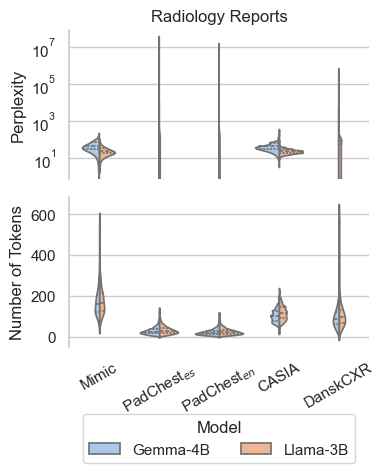

In [9]:
sns_data = data.copy()

sns.set(style="whitegrid")
# Filter to the models you want
show_models = ["Llama-3B", "Gemma-4B"] # "Gemma-4B"
show_languages = ["mimic", "padchest", "padchest_EN", "danskcxr", "casia"]
sns_data = sns_data[sns_data['model'].isin(show_models)]
sns_data = sns_data[sns_data['language'].isin(show_languages)]

def dataset_mapping(ds):
    mapping = {
        "mimic": "Mimic",
        "padchest": "PadChest$_{es}$",
        "padchest_EN": "PadChest$_{en}$",
        "casia": "CASIA",
        "danskcxr": "DanskCXR"
    }
    return mapping.get(ds, ds)
sns_data['language'] = sns_data['language'].apply(dataset_mapping)

# Create stacked violin plots
fig, axes = plt.subplots(2, 1, figsize=(4, 5), sharex=True)

# Top plot: ppl
sns.violinplot(data=sns_data, x="language", y="ppl", hue="model", split=True, inner="quart", ax=axes[0], palette="pastel")
axes[0].set_title("Radiology Reports")
axes[0].set_ylabel("Perplexity")
axes[0].get_legend().remove() # turn off legend
axes[0].set_yscale('log')


# Bottom plot: len
sns.violinplot(data=sns_data, x="language", y="len_input_ids", hue="model", split=True, inner="quart", ax=axes[1], palette="pastel")
axes[1].set_title("")
axes[1].set_ylabel("Number of Tokens")
axes[1].set_xlabel("")
# move legend outside under the plots
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=len(show_models), title="Model")
#rotate x-axis labels 45 degrees
plt.xticks(rotation=30)

plt.tight_layout()
sns.despine(bottom=True)
plt.show()


/tmp/ipykernel_726549/3561883353.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_726549/3561883353.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_726549/3561883353.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_726549/3561883353.py:14: Matplotli

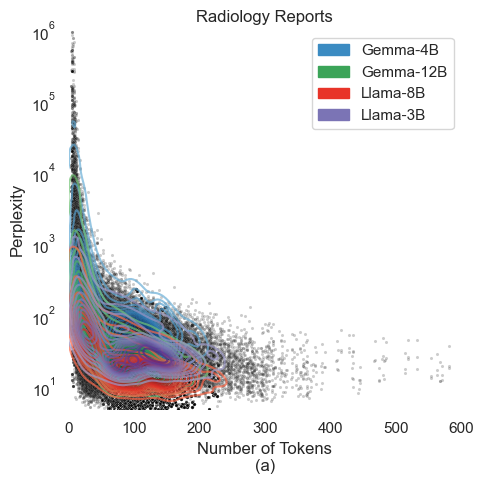

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

sns_data = data.copy()  # Assumes 'data' is your source DataFrame

sns.set_style("white")

# Lambda to create a colormap skipping the lightest 50%
custom_cmap = lambda base_cmap: ListedColormap(
    plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
)

show_languages = ["mimic", "padchest", "padchest_EN", "danskcxr", "casia"]
sns_data = sns_data[sns_data['language'].isin(show_languages)]

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)

# KDE plots with contour-only style
sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Gemma-4B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Blues"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7,
    levels=15,        # more contour lines
)

sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Gemma-12B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Greens"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7,
    levels=15,        # more contour lines
)

sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Llama-8B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Reds"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7,
    levels=15,        # more contour lines
)

sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Llama-3B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Purples"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7,
    levels=15,        # more contour lines
)

sns.scatterplot(
    data=sns_data,
    x="len_input_ids",
    y="ppl",
    color="black",
    alpha=0.2,
    s=5,
    ax=axes,
    rasterized=True
)

axes.set_title("Radiology Reports")
axes.set_ylabel("Perplexity")
axes.set_xlabel("Number of Tokens\n(a)")
axes.set_ylim(-5, 10**6)
axes.set_xlim(0, 600)

# Legend patches from same bright colormaps
gemma4_patch = mpatches.Patch(color=custom_cmap("Blues")(0.3), label="Gemma-4B")
gemma12_patch = mpatches.Patch(color=custom_cmap("Greens")(0.3), label="Gemma-12B")
llama8_patch = mpatches.Patch(color=custom_cmap("Reds")(0.3), label="Llama-8B")
llama3_patch = mpatches.Patch(color=custom_cmap("Purples")(0.3), label="Llama-3B")

axes.legend(handles=[gemma4_patch, gemma12_patch, llama8_patch, llama3_patch], loc='upper right')

plt.tight_layout()
sns.despine(left=True, bottom=True)

plt.savefig("/home/alice/work/mosaic/outputs/ppl_plots/perplexity_reports_models.pdf", dpi=150, format='pdf')
plt.show()


/tmp/ipykernel_693991/1988613358.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = lambda base_cmap: ListedColormap(plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256)))
/tmp/ipykernel_693991/1988613358.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = lambda base_cmap: ListedColormap(plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256)))
/tmp/ipykernel_693991/1988613358.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom

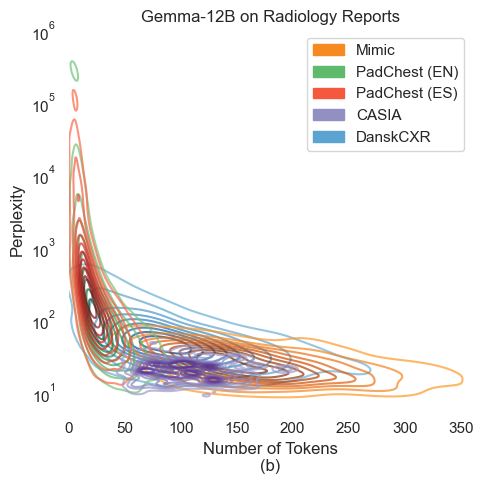

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

sns_data = data.copy()  # Assumes 'data' is your source DataFrame

sns.set_style("white")  # keep gridlines visible

# Lambda to create a colormap skipping the lightest 30%
custom_cmap = lambda base_cmap: ListedColormap(plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256)))

show_models = ["Gemma-12B"]
sns_data = sns_data[sns_data['model'].isin(show_models)]

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)

# Apply lambda to each KDE plot
sns.kdeplot(
    data=sns_data[sns_data['language'] == 'danskcxr'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Blues"),
    ax=axes,
    log_scale=(False, True), 
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['language'] == 'mimic'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("YlOrBr"),
    ax=axes,
    log_scale=(False, True), 
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['language'] == 'padchest'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Greens"),
    ax=axes,
    log_scale=(False, True), 
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['language'] == 'padchest_EN'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Reds"),
    ax=axes,
    log_scale=(False, True), 
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['language'] == 'casia'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Purples"),
    ax=axes,
    log_scale=(False, True), 
    alpha=0.7
)

axes.set_title("Gemma-12B on Radiology Reports")
axes.set_ylabel("Perplexity")
axes.set_xlabel("Number of Tokens\n(b)")
axes.set_ylim(-5, 10**6)
axes.set_xlim(0, 360)

# Legend
import matplotlib.patches as mpatches

mimic_patch = mpatches.Patch(color=custom_cmap("YlOrBr")(0.1), label="Mimic")
padchest_patch = mpatches.Patch(color=custom_cmap("Greens")(0.1), label="PadChest (EN)")
padchesten_patch = mpatches.Patch(color=custom_cmap("Reds")(0.1), label="PadChest (ES)")
casia_patch = mpatches.Patch(color=custom_cmap("Purples")(0.1), label="CASIA")
danskcxr_patch = mpatches.Patch(color=custom_cmap("Blues")(0.1), label="DanskCXR")

axes.legend(handles=[mimic_patch, padchest_patch, padchesten_patch, casia_patch, danskcxr_patch], loc='upper right')

plt.tight_layout()
sns.despine(left=True, bottom=True)

plt.savefig("/home/alice/work/mosaic/outputs/ppl_plots/perplexity_reports_gemma12b.pdf")
plt.show()


/tmp/ipykernel_693991/1734035847.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_693991/1734035847.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_693991/1734035847.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_693991/1734035847.py:14: Matplotli

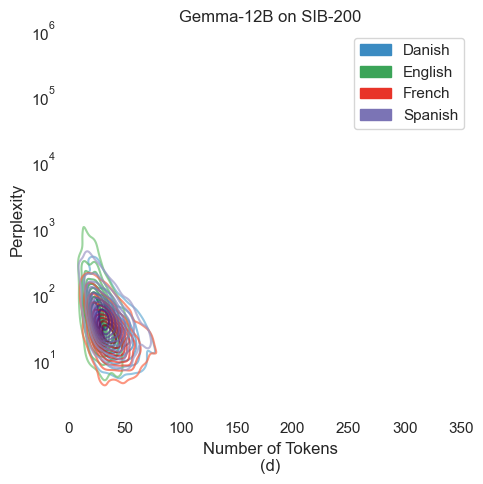

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

sns_data = data.copy()  # Assumes 'data' is your source DataFrame

sns.set_style("white")  # clean style

# Lambda to create a colormap skipping the lightest 50%
custom_cmap = lambda base_cmap: ListedColormap(
    plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
)

show_models = ["Gemma-12B"]
sns_data = sns_data[sns_data['model'].isin(show_models)]

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)

# Apply custom_cmap to each KDE plot with fill=False
sns.kdeplot(
    data=sns_data[sns_data['language'] == 'danish'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Blues"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['language'] == 'english'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Greens"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['language'] == 'french'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Reds"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['language'] == 'spanish'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Purples"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

axes.set_title("Gemma-12B on SIB-200")
axes.set_ylabel("Perplexity")
axes.set_xlabel("Number of Tokens\n(d)")
axes.set_ylim(-5, 10**6)
axes.set_xlim(0, 360)

# Legend colors to match custom_cmap
danish_patch = mpatches.Patch(color=custom_cmap("Blues")(0.3), label="Danish")
english_patch = mpatches.Patch(color=custom_cmap("Greens")(0.3), label="English")
french_patch = mpatches.Patch(color=custom_cmap("Reds")(0.3), label="French")
spanish_patch = mpatches.Patch(color=custom_cmap("Purples")(0.3), label="Spanish")

axes.legend(handles=[danish_patch, english_patch, french_patch, spanish_patch], loc='upper right')

plt.tight_layout()
sns.despine(left=True, bottom=True)

plt.savefig("/home/alice/work/mosaic/outputs/ppl_plots/perplexity_sib_gemma12b.pdf")
plt.show()

/tmp/ipykernel_693991/3359814846.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_693991/3359814846.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_693991/3359814846.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
/tmp/ipykernel_693991/3359814846.py:14: Matplotli

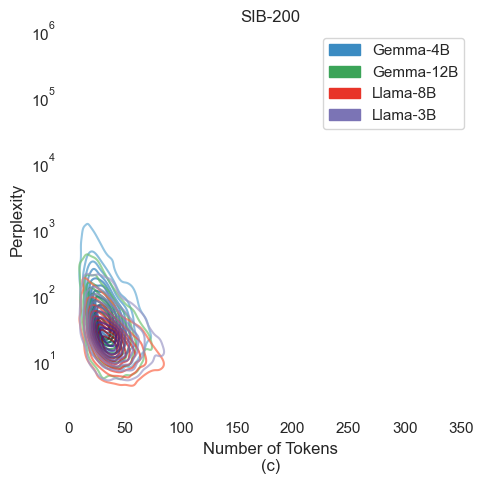

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

sns_data = data.copy()  # Assumes 'data' is your source DataFrame

sns.set_style("white")  # clean style

# Lambda to create a colormap skipping the lightest 50%
custom_cmap = lambda base_cmap: ListedColormap(
    plt.cm.get_cmap(base_cmap)(np.linspace(0.5, 1, 256))
)

show_languages = ["french", "danish", "english", "spanish"]
sns_data = sns_data[sns_data['language'].isin(show_languages)]

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)

# Plot each model with contour-only KDE
sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Gemma-4B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Blues"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Gemma-12B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Greens"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Llama-8B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Reds"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

sns.kdeplot(
    data=sns_data[sns_data['model'] == 'Llama-3B'],
    x="len_input_ids",
    y="ppl",
    fill=False,
    cmap=custom_cmap("Purples"),
    ax=axes,
    log_scale=(False, True),
    alpha=0.7
)

axes.set_title("SIB-200")
axes.set_ylabel("Perplexity")
axes.set_xlabel("Number of Tokens\n(c)")
axes.set_ylim(-5, 10**6)
axes.set_xlim(0, 360)

# Legend patches that match the brighter colormaps
gemma4_patch = mpatches.Patch(color=custom_cmap("Blues")(0.3), label="Gemma-4B")
gemma12_patch = mpatches.Patch(color=custom_cmap("Greens")(0.3), label="Gemma-12B")
llama8_patch = mpatches.Patch(color=custom_cmap("Reds")(0.3), label="Llama-8B")
llama3_patch = mpatches.Patch(color=custom_cmap("Purples")(0.3), label="Llama-3B")

axes.legend(handles=[gemma4_patch, gemma12_patch, llama8_patch, llama3_patch], loc='upper right')

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig("/home/alice/work/mosaic/outputs/ppl_plots/perplexity_sib_models.pdf")
plt.show()